# Investigation of ODI Cricket Data

With one of the most dramatic One Day International (ODI) Cricket World Cups there has ever been behind us, here we'll have a close look at some of the statistics behind this weird and wonderful game.

### ODI Cricket Overview

- Each team has 11 players
- Each team has a single 50 over innings (6 balls in an over), to amas their score. The innings ends when they reach 50 overs, lose 10 wickets or catch their oponents score.
- The batting order is decided by the team captain after a coin toss

### Data
The data used in this report has been has been downloaded from [this kaggle kernel](https://www.kaggle.com/venky73/icc-cricket-world-cup-2019-analysis), with some additional data collected directly from [https://www.espncricinfo.com/](https://www.espncricinfo.com/). The data gathering and cleaning process is documented in [ODI_Cricket_Wrangle](ODI_Cricket_Wrangle.ipynb). 

The set contains data collected between 2013 and 2019 up until just before the Cricket World Cup.

## Questions

Here are some of the questions that we'll try to answer with the data:

**Win Percentages:**
1. Which team has the highest win percentage overall and in England?
1. How does batting order and coint toss affect?
1. How does a losing or winning a match impact on the result of their next game?

**Score and runs per over:**
1. What is the relationship between team scores and runs per over?
1. How does winning the toss and batting order affect the scoring rates?
1. How have the scoring average and scoring rates change between 2013 - 2019?

**Overall Performance:**
1. What is a good target score for a team to aim for in order to win the game?

We'll conclude by recommending targets for the best winning formular.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.lines as mlines

%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)
assert '/home/ding/coding/machine_learning/ODI_cricket/src' in sys.path
from visualization import visualize as vis

df_match = pd.read_csv('../Data/processed/ODI_match_clean.csv')
df_totals = pd.read_csv('../Data/processed/ODI_totals_clean.csv')

# Update column data types
df_match.start_date = pd.to_datetime(df_match.start_date)
cat_cols = ['team1', 'team2', 'ground', 'result']
for col in cat_cols:
    df_match[col] = df_match[col].astype('category')
    
df_totals.start_date = pd.to_datetime(df_totals.start_date)
cat_cols = ['country', 'opposition', 'result','bat']
for col in cat_cols:
    df_totals[col] = df_totals[col].astype('category')
    
c=sb.color_palette()

## Analysis
Lets go through the questions in order and see what conclusions can be drawn from the data.
***

Lets start by mapping out what time of year most teams play their matches.

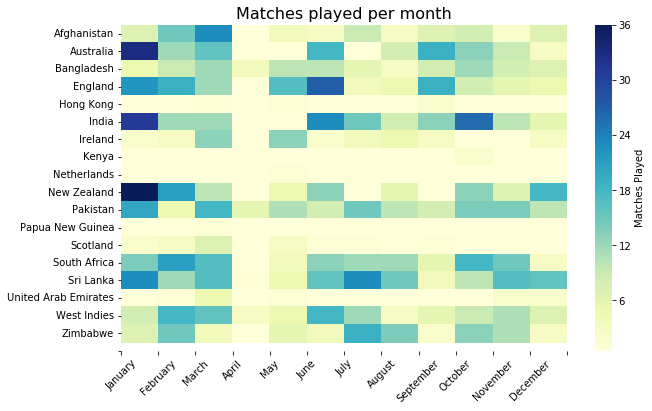

In [3]:
df_temp= df_totals.copy()
df_temp['month'] = df_temp.start_date.dt.month
df_temp['month'] = df_temp.month.astype('category')

grouped = df_temp.groupby(['country', 'month']).count()['match_id']
values = np.where(grouped.isnull(), 0, grouped)
values = values.reshape(18,12)

plt.figure(figsize=[10,6])
sb.heatmap(values, vmin=0.5, cmap='YlGnBu', cbar_kws={'label':'Matches Played'}, annot=False);

y_locs, y_labels = plt.yticks()
x_locs, x_labels = plt.xticks()

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']

plt.xticks(np.arange(0,13,1), months, rotation=45);
plt.yticks(np.arange(0.5,19.5,1), grouped.index.levels[0], rotation=0, va='center');
plt.title("Matches played per month", fontsize=16);

- The heatmap hows us that there are almost zero matches in the dataset which are played in April. Perhaps this marks the end of the cricket season in some areas of the worl and is before the start of the season elsewhere.
- We can also see that Kenya, Netherlands, Papau New Guinea, Scotland and United Arab Emirates have not played many macthes.
***

### Win Percentages
Now lets look into the win percetanges of each team to answer the questions raised earlier.

1. Which team has the highest win percentage overall and in England?
1. How does batting order and coint toss affect?
1. How does a losing or winning a match impact on the result of their next game?

In [4]:
df_pcnts = df_totals.copy()
df_pcnts = df_pcnts.merge(df_match.loc[:,['match_id','ground']], on='match_id')
df_pcnts.country = df_pcnts.country.astype(object)
df_pcnts = df_pcnts[df_pcnts.result.isin(['won','lost', 'tied'])]
df_pcnts['result_dum'] = np.where(df_pcnts.result=="won",1,0)

/home/ding/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/ding/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ding/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


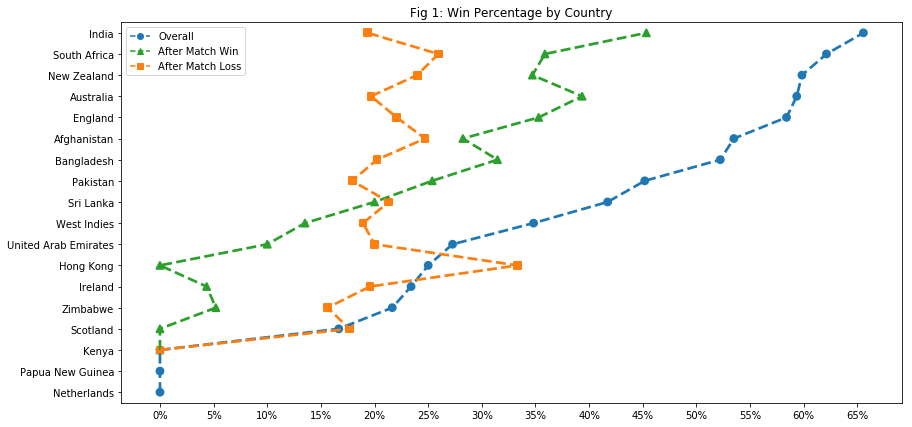

In [5]:
# Overall win proportions
win_prop = df_pcnts.groupby('country').mean()['result_dum'].sort_values()
order= win_prop.index

# Win after result proportions
lose_win_prop = vis.winAfterLoss(df_pcnts, order)
win_win_prop = vis.winAfterWin(df_pcnts, order)

plt.figure(figsize=[14,7])
s1 = sb.pointplot(x=win_prop.values, y=win_prop.index, order=order, color=c[0], 
                      linestyles='--', markers='o')
s2 = sb.pointplot(x=win_win_prop.values.flatten(), y=win_win_prop.index, order=order, color=c[2], 
                      linestyles='--', markers='^')
s3 = sb.pointplot(x=lose_win_prop.values.flatten(), y=lose_win_prop.index, order=order, color=c[1], 
                      linestyles='--', markers=',')

l0 = mlines.Line2D([],[],color=c[0], linestyle='--', marker='o')
l1 = mlines.Line2D([],[],color=c[1], linestyle='--', marker='s')
l2 = mlines.Line2D([],[],color=c[2], linestyle='--', marker='^')



plt.legend((l0,l2,l1), ('Overall', 'After Match Win', 'After Match Loss'), title="")

plt.title("Fig 1: Win Percentage by Country");
plt.gca().invert_yaxis();

ticks = np.arange(0,0.7,0.05)
labels = ['{:.0f}%'.format(i*100) for i in ticks]

plt.xticks(ticks, labels)
plt.ylabel("");
plt.xlabel("");

- Figure 1 shows the overall win percentage per team alongside the breakdown of whether those wins occur after a match win or a match loss.
- India are the most successful team in terms of overall win percentage and proportion of win streaks.
- The top 10 countries in this table are the countries which took part in this years world cup. Lets see how they perform on English soil.

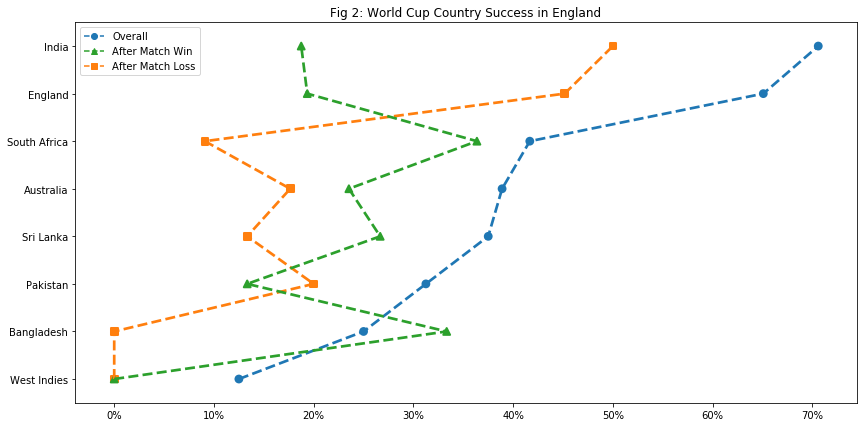

In [5]:
english_grounds = ['The Oval', 'Birmingham', 'Cardiff', 'Nottingham', 'Southampton', 'Leeds', "Lord's", 
                   'Manchester', 'Chester-le-Street', 'Bristol', 'East London']
cup_countries = ['Afghanistan', 'Australia', 'Bangladesh', 'England', 'India', 'Pakistan', 
                 'South Africa', 'Sri Lanka', 'West Indies']

# Win proportions in England
win_prop = df_pcnts[(df_pcnts.ground.isin(english_grounds))&
                      (df_pcnts.country.isin(cup_countries))].groupby('country').mean()['result_dum'].sort_values()
order= win_prop.index

# Proportions after match result
win_win_prop = vis.winAfterWin(df_pcnts[(df_pcnts.ground.isin(english_grounds))&(df_pcnts.country.isin(cup_countries))],
                              countries=cup_countries)
lose_win_prop = vis.winAfterLoss(df_pcnts[(df_pcnts.ground.isin(english_grounds))&(df_pcnts.country.isin(cup_countries))],
                              countries=cup_countries)

plt.figure(figsize=[14,7])
sb.pointplot(x=win_prop.values, y=win_prop.index, color=c[0], order=order, linestyles='--', markers='o');
sb.pointplot(x=win_win_prop.values.flatten(), y=win_win_prop.index, color=c[1], order=order, linestyles='--', markers='s');
sb.pointplot(x=lose_win_prop.values.flatten(), y=lose_win_prop.index, color=c[2], order=order, linestyles='--', markers='^');

l0 = mlines.Line2D([],[],color=c[0], linestyle='--', marker='o')
l1 = mlines.Line2D([],[],color=c[1], linestyle='--', marker='s')
l2 = mlines.Line2D([],[],color=c[2], linestyle='--', marker='^')

plt.legend((l0,l2,l1), ('Overall', 'After Match Win', 'After Match Loss'), title="")

plt.title("Fig 2: World Cup Country Success in England");
plt.gca().invert_yaxis();

ticks = np.arange(0,0.8,0.1)
labels = ['{:.0f}%'.format(i*100) for i in ticks]

plt.xticks(ticks, labels)
plt.ylabel("");
plt.xlabel("");


- India and England are the most successful teams on English grounds.
- India sit atop this chart and the overall charts. Its clear to see why they were strong contenders going into this World Cup. 
- Afghanistan have not played in any matches in England so were a mystery team heading into the World Cup.
- South Africa are the most dangerous team when on a winning streak in england, winning over 35% of their matches having won their previous match.
***
Lets look at the team performances vs the batting order and result of the coin toss.

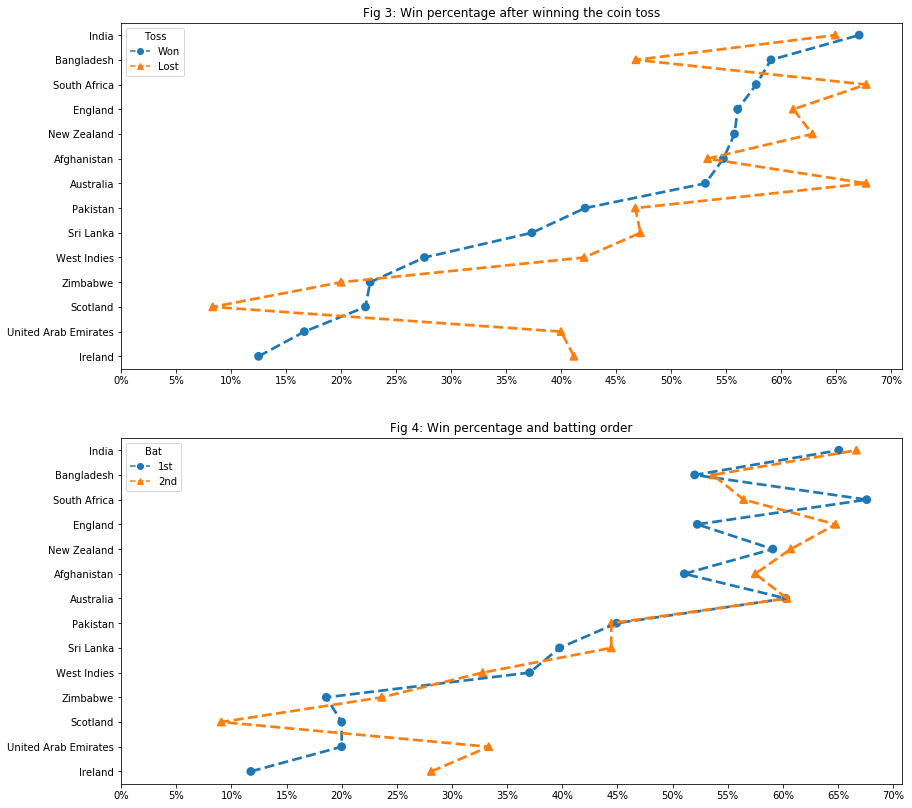

In [6]:
# Win after winning toss proportions
win_win = df_pcnts[df_pcnts.toss=='won'].groupby('country').mean()['result_dum'].sort_values().dropna().tail(14)
order = win_win.index

# Win after losing toss proportions
lose_win = df_pcnts[df_pcnts.toss=='lost'].groupby('country').mean()['result_dum'][order].dropna()

ticks = np.arange(0,0.75,0.05)
labels = ['{:.0f}%'.format(i*100) for i in ticks]

plt.subplots(2,1,figsize=[14,14]);
plt.subplot(2,1,1);
s1 = sb.pointplot(x=win_win.values, y=win_win.index, order=order, color=c[0], 
                      linestyles='--', markers='o')

s2 = sb.pointplot(x=lose_win.values, y=lose_win.index, order=order, color=c[1], 
                      linestyles='--', markers='^')

l0 = mlines.Line2D([],[],color=c[0], linestyle='--', marker='o')
l1 = mlines.Line2D([],[],color=c[1], linestyle='--', marker='^')

plt.legend((l0,l1), ('Won', 'Lost'), title="Toss")

plt.title("Fig 3: Win percentage after winning the coin toss");
plt.gca().invert_yaxis();

plt.xticks(ticks, labels)
plt.ylabel("");
plt.xlabel("");




# Win after batting 1st proportions
bat1win= df_pcnts[df_pcnts.bat=='1st'].groupby('country').mean()['result_dum'].sort_values()[order]

# Win after batting 2nd proportions
bat2win = df_pcnts[df_pcnts.bat=='2nd'].groupby('country').mean()['result_dum'][order][order]

plt.subplot(2,1,2);
s1 = sb.pointplot(x=bat1win.values, y=bat1win.index, order=order, color=c[0], linestyles='--', markers='o')

s2 = sb.pointplot(x=bat2win.values, y=bat2win.index, order=order, color=c[1], linestyles='--', markers='^')

l0 = mlines.Line2D([],[],color=c[0], linestyle='--', marker='o')
l1 = mlines.Line2D([],[],color=c[1], linestyle='--', marker='^')

plt.legend((l0,l1), ('1st', '2nd'), title="Bat")

plt.title("Fig 4: Win percentage and batting order");
plt.gca().invert_yaxis();

plt.xticks(ticks, labels)
plt.ylabel("");
plt.xlabel("");

#### Coin Toss
- Fig 3 shows some interesting results. In general, the team who loses the coin toss wins a higher proportion of matches. Perhaps there is less pressure on them to justify the batting decision made by their captain.

#### Batting Order
- In most cases there is marginal difference in a teams overall win percentage when batting first or second. 
- England have more success when batting second, winning 10% more of their matches when batting second.
- Afghanistan also have more success when batting second, winning 5% more of their matches when batting second.
- South Africa win nearly 10% more of their matched when batting first.

## Score and runs per over
Lets now look at the relationship between total score and runs per over and answer the qestions raised earlier.
1. What is the relationship between team scores and runs per over?
1. How does winning the toss and batting order affect the scoring rates?
1. How have the scoring average and scoring rates change between 2013 - 2019?

In [7]:
df_temp=df_totals.copy()
df_temp['year'] = df_temp.start_date.dt.year

/home/ding/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


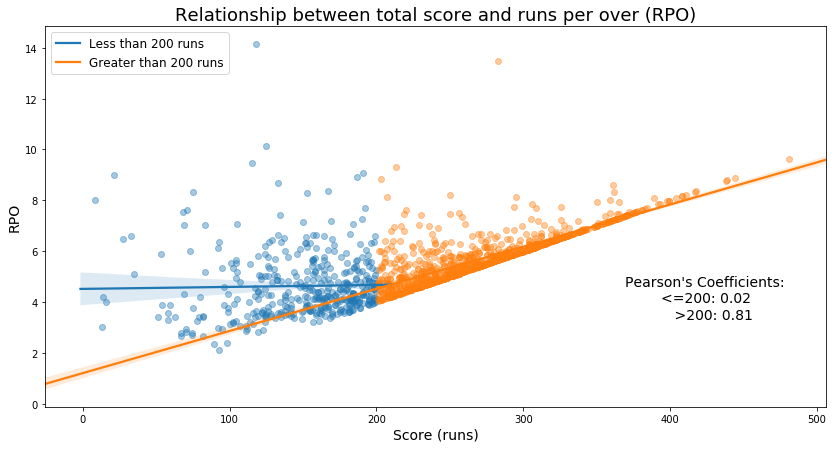

In [8]:
fig = plt.figure(figsize=[14,7])

sb.regplot(data=df_temp[df_temp.score_total <= 200], y='rpo', x='score_total', scatter_kws={'alpha':0.4});
sb.regplot(data=df_temp[df_temp.score_total > 200], y='rpo', x='score_total', scatter_kws={'alpha':0.4});

plt.title("Relationship between total score and runs per over (RPO)", fontsize=18);

plt.legend(fontsize=12,labels=['Less than 200 runs', 'Greater than 200 runs'], loc=2);
plt.xlabel("Score (runs)", fontsize=14);
plt.ylabel("RPO", fontsize=14);

corr1 = df_temp[df_temp.score_total <= 200].rpo.corr(df_temp[df_temp.score_total <= 200].score_total)
corr2 = df_temp[df_temp.score_total > 200].rpo.corr(df_temp[df_temp.score_total > 200].score_total)

fig.text(0.7,0.3, "Pearson's Coefficients:\n        <=200: {:.2f}\n           >200: {:.2f}".format(corr1, corr2),
        fontsize=14);

This chart shows some fairly interesting trends.
- Scores less than 200 runs has almost no positive correlation with rpo, with a pearsons cofficient of 0.02.
- Scores greater than 200 runs have a strong positive correlation with rpo, with a pearsons cofficient of 0.81.
- This increase in correlation strength gives rise to the hockey stick shape of the distribution.
- There is a dense line of points which form a baseline of which there are no points below. Scores below this line are impossible to achieve in 50 overs with that value of rpo.

### Coin Toss and Run Rate

We saw earlier that for most teams there was very little difference in win percentage when batting first or second, but how is the average score affected?

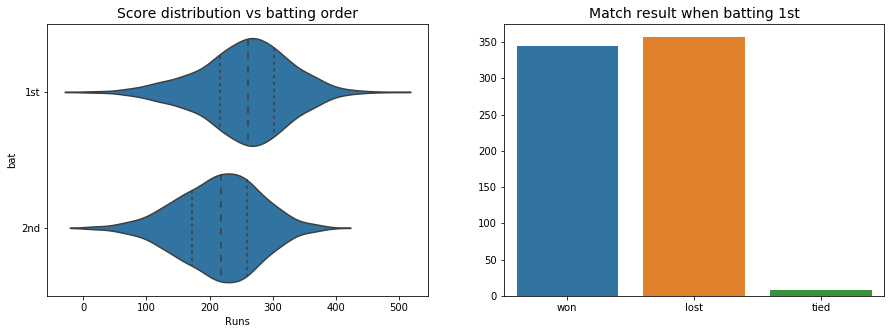

In [9]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
sb.violinplot(data=df_totals, y="bat", x='score_total', color=c[0], inner='quartile', order=['1st','2nd']);
plt.title("Score distribution vs batting order", fontsize=14);
plt.xlabel("Runs")

plt.subplot(1,2,2)
sb.barplot(x=['won', 'lost','tied'], y=[((df_totals.result=="won") & (df_totals.bat=="1st")).sum(), 
                                    ((df_totals.result=="lost") & (df_totals.bat=="1st")).sum(),
                                       ((df_totals.result=="tied") & (df_totals.bat=="1st")).sum()]);
plt.title("Match result when batting 1st", fontsize=14);

- Here we see that the average score for teams batting second is around 50 runs less than a team batting first, yet the number of matched won by teams battinf first is slightly less than teams batting second.
- This is because it is impossible for a team battting second to surpass the score of the team batting first by more than 6 runs since the game finishes when they reach this point, regardless off the number of overs bowled.
- Because of this, we'll use the average runs per over of a team as a measure of score performance.

Lets look at pattern of average rpo for each team over the years.

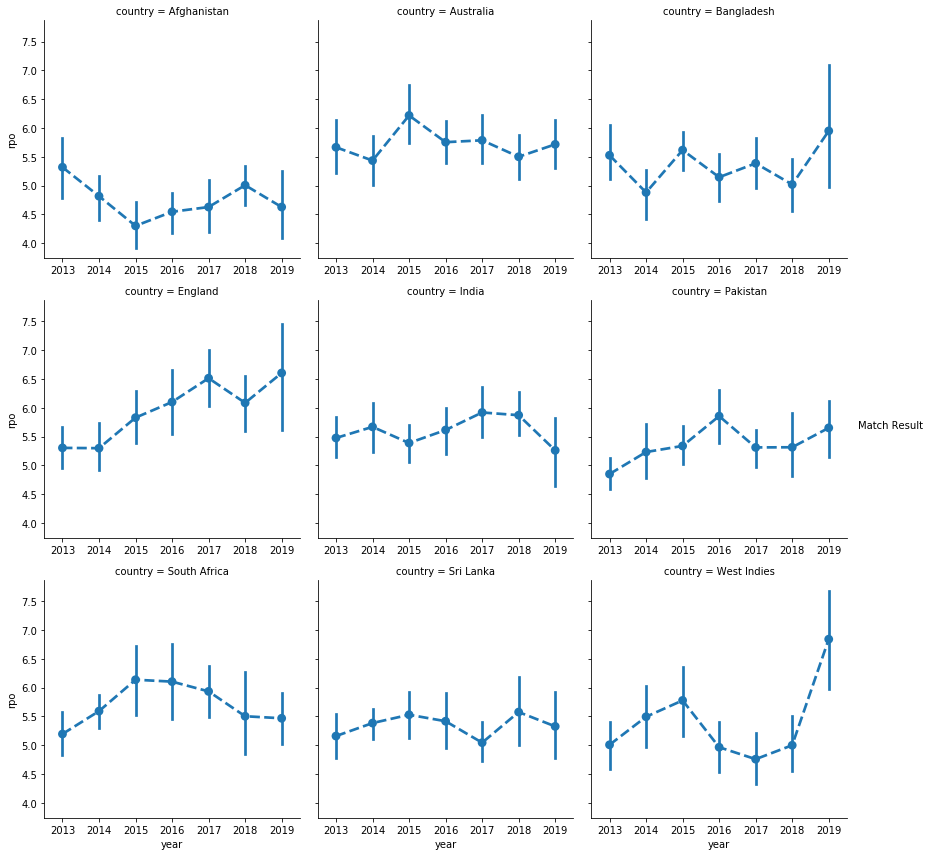

In [10]:
def pointplot(x,y,hue,**kwargs):
    sb.pointplot(x=x,y=y, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_temp, col='country', col_order=cup_countries, col_wrap=3, height=4, sharex=False)
g.map(pointplot, 'year', 'rpo', hue=None, color=c[0], linestyles='--', ci=95)
g.add_legend(title="Match Result");

- The average rpo's for each team generally oscillate around an average.
- Enlgand have shown the most consistent improvemnet of rpo since 2013, increassing by almost 0.5 runs per over each year.
- The West Indies see a significant increase in there average rpo for 2019, however, with not many matches played yet the average is more susceptible to skew from extreme results.

Lets now look at how runs per over relates to the result of the match.

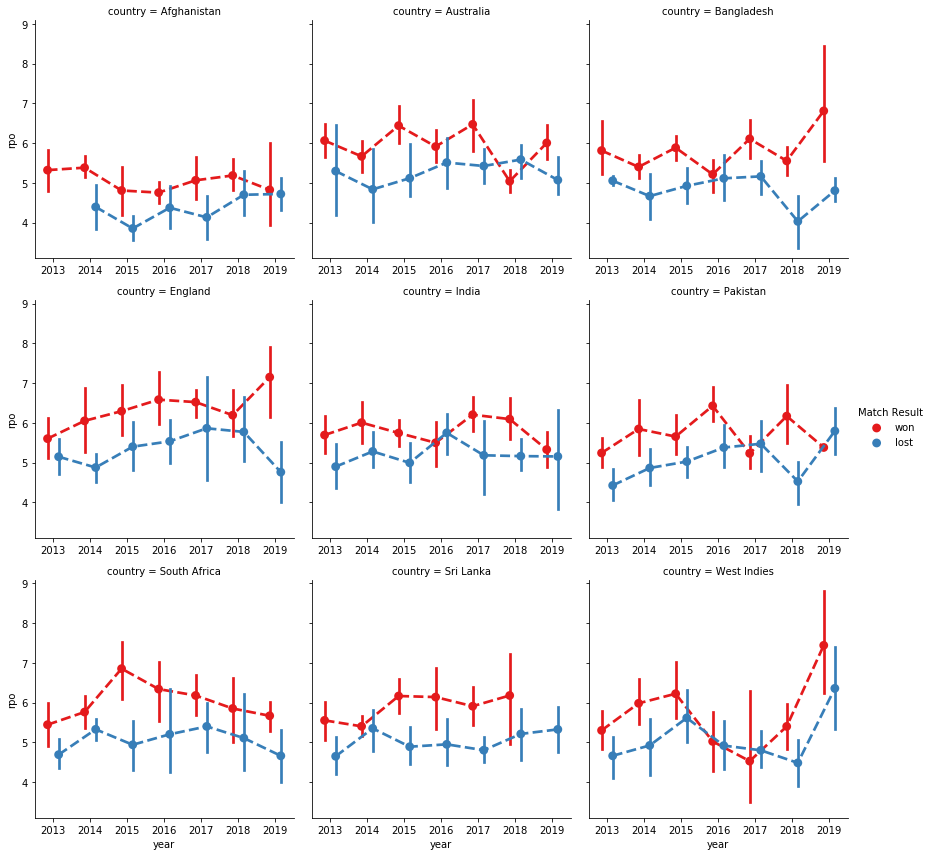

In [11]:
def pointplot(x,y,hue,**kwargs):
    sb.pointplot(x=x,y=y, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_temp, col='country', col_order=cup_countries, col_wrap=3, height=4, sharex=False)
g.map(pointplot, 'year', 'rpo', 'result', hue_order=['won','lost'], dodge=0.3, palette="Set1", linestyles='--', ci=95)
g.add_legend(title="Match Result");

As we might expect that the average rpo for each team is higher for games in which they win than ones where they lose. However, there are some interesting exceptions.
- In 2018, Australia won more games when scoring a lower rpo.
- We see the same for the West indies and Pakistan in 2017.
- Due to overalap of the 95% confidence intervals we cannot be certain that these observation do not arise through random chance.


## Overall Performance Recommendations
1. What is a good target score for a team to aim for in order to win the game?

In [12]:
ground_avg_score = df_pcnts.groupby('ground').mean()['score_total']
df_pcnts['score_vs_avg'] = np.NaN

for ground, avg in zip(ground_avg_score.index, ground_avg_score.values):
    df_pcnts['score_vs_avg'] = np.where(df_pcnts.ground == ground, df_pcnts.score_total - avg, df_pcnts.score_vs_avg)

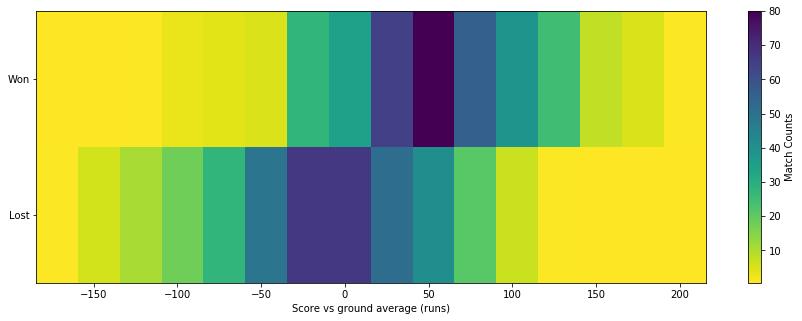

In [13]:
bins = np.arange(df_pcnts.score_vs_avg.min(), df_pcnts.score_vs_avg.max()+25,25)

plt.figure(figsize=[15,5])
h2 = plt.hist2d(data=df_pcnts[df_pcnts.bat=='1st'], x='score_vs_avg', y='result_dum', bins=[bins, [0,0.5,1]], vmin=0.5,
               cmap='viridis_r');
plt.yticks((0.25,0.75),('Lost','Won'))
plt.xlabel("Score vs ground average (runs)")
plt.colorbar(label='Match Counts');

- Here we have engineered the new feature `score_vs_avg` which calculates the score as a delta against the ground average calculated from the full sample games played at each ground.
- The dataset is filtered to only include the scores from teams who batted 1st to avoid the left skew created by the scores of winning teams who bat 2nd.

**Observations:**
- The heatmap shows the disitrbution of losing scores vs the ground average is centred aroind -10 runs, with the distribution of winning results centred around +50 runs. 

Lets look at the distribution of wickets lost during an innings vs the match result.

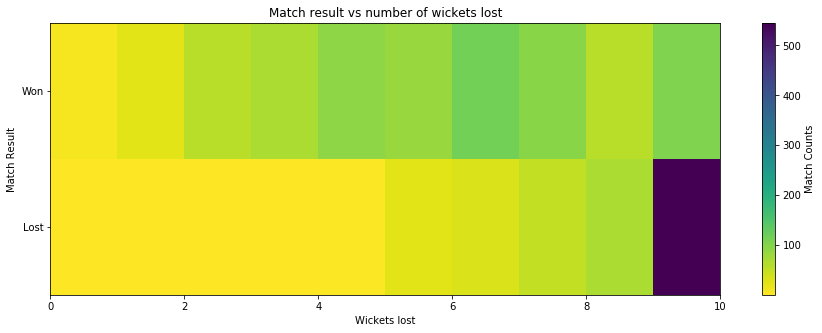

In [14]:
bins = np.arange(0,11,1)

plt.figure(figsize=[15,5])
h2 = plt.hist2d(data=df_pcnts, x='wickets', y='result_dum', bins=[bins, [0,0.5,1]], vmin=0.5, cmap='viridis_r');
plt.title("Match result vs number of wickets lost")
plt.yticks((0.25,0.75),('Lost','Won'))
plt.xlabel("Wickets lost")
plt.ylabel("Match Result")
plt.colorbar(label='Match Counts');

- Teams that lose all 10 wickets in there innings are very likely to lose the match
- Teams who lose less than 5 wickets are unlikely to lose the match.
- There is relatively even distribution of wickets lost for teams who won the match.

## Conclusions & Recommendations
We have seen some interesting and curious trends within that data. Here are the key points and recommendations:
- India and England are the most prolific team in English conditions, winning 20-25% more matches in England than their next best rival, South Africa
- South Africa are the most dangerous team when on a winning streak in england, winning over 35% of their matches having won their previous match.
- In general, batting first or second had little affect on a teams success, but **losing** the toss benefited most teams.
- England have shown the most consistent improvement in runs scored per over. Combine this with their success on home soil they are a force to be reckoned with.
- Teams who score greater than the average score on that ground and lose less than 5 wickets are much less likely to lose.

My final recommendation to all teams in the world cup are:
- Lose the coin toss
- Aim to score 50 runs more than the average runs scored on that ground.
- Aim to lose less than 5 wickets in their innings.

Thank you for reading!